### Advanced Machine Learning

# Topic Models & Word Embeddings

02/05/21

Jonathan Schler

(credit: Columbia Univ - 4995 - Machine Learning Course)





# Beyond Bags of Words

Limitations of bag of words:
- Semantics of words not captured
- Synonymous words not represented
- Very distributed representation of documents



# Topic Models



# Motivation

- Each document is created as a mixture of topics
- Topics are distributions over words
- Learn topics and composition of documents simultaneously
- Unsupervised (and possibly ill-defined)


# Latent Dirichlet Allocation
# (the other LDA)
(Not Linear Discriminant Analysis)



# The LDA Model


<center>
<img src="./images/lda_model.png" style="width: 600px;">
</center>

(stolen from Dave and John)





<center>
<img src="./images/lda_params.png" style="width: 600px;">
</center>



- For each topic $k$, draw $\phi_k \sim \text{Dirichlet}(\beta), k = 1 ... K$
- For each document $d$ draw $\theta_d \sim \text{Dirichlet}(\alpha), d = 1 ... D$
- For each word $i$ in document $d$:
	* Draw a topic index $z_{di} \sim \text{Multinomial}(\theta_d)$
	* Draw the observed word $w_{ij} \sim \text{Multinomial}(\phi_z)$


- (taken from Yang Ruan, Changsi An (http://salsahpc.indiana.edu/b649proj/proj3.html)





## Multinomial

It models the probability of counts for rolling a k-sided die n times.
[wikipedia]


$$ P(x_1, \dots, x_k |n, p_1, \dots, p_k) = \frac{n!}{x_1! \dots x_k!} p_1^{x_1} \dots p_k^{x^k}$$





## Dirichlet
$$ P(x_1, \dots, x_k | \alpha_1, \dots \alpha_k)=\frac{1}{B(\alpha)} x_1^{\alpha_1 - 1} \dots x_k^{\alpha_k - 1} $$








# Conjugate Prior

- Prior is called "conjugate" of the posterior has the same form as prior
$$ P(\theta | x) = \frac{p(x | \theta)p(\theta)}{\int_{}^{} p(x | \theta^\prime)p(\theta^\prime)d\theta^\prime} $$



# Dirichlet Distributions


PDF:
$\qquad \frac{1}{B(\alpha)} \Pi_{i=1}^{K}{x_i^{\alpha_i - 1}}$



Mean:
$\qquad E[X_i] = \frac{\alpha_i}{\sum_k{\alpha_k}}$

<center>
<img src="./images/dirichlet_dist.png" style="width: 600px;">
</center>




<img src="./images/lda_params.png" style="width: 600px;">

- For each topic $k$, draw $\phi_k \sim \text{Dirichlet}(\beta), k = 1 ... K$
- For each document $d$ draw $\theta_d \sim \text{Dirichlet}(\alpha), d = 1 ... D$
- For each word $i$ in document $d$:
	* Draw a topic index $z_{di} \sim \text{Multinomial}(\theta_d)$
	* Draw the observed word $w_{ij} \sim \text{Multinomial}(\beta_z)$


- (taken from Yang Ruan, Changsi An (http://salsahpc.indiana.edu/b649proj/proj3.html)




# Two Schools (of solvers)


Gibbs Sampling
- Implements MCMC
- Standard procedure for any probabilistic model
- Very accuracte
- Very slow


Variational Inference
- Extension of expectation-maximization algorithm
- Deterministic
- fast(er)
- Less accurate solutions



# Pick a solver

- “Small data” (<= 10k? Documents):
	* Gibbs sampling (lda package, MALLET in Java)
- “Medium data” (<= 1M? Documents):
	* Variational Inference (scikit-learn default)
- “Large Data” (>1M? Documents):
	* Stochastic Variational Inference
	* SVI allows online learning (partial_fit)

- Tensorflow Probability https://www.tensorflow.org/probability
  * Tensor-flow based framework for stochastic variational inference.
 

In [1]:
# Data loading

from sklearn.datasets import load_files
import numpy as np
reviews_train = load_files("../L09-text-data/data/aclImdb/train/")

text_trainval, y_trainval = reviews_train.data, reviews_train.target
print("type of text_train: ", type(text_trainval))
print("length of text_train: ", len(text_trainval))
print("class balance: ", np.bincount(y_trainval))

#[d.replace("<br />"," ") for d in text_trainval[0:4].encode()]

type of text_train:  <class 'list'>
length of text_train:  25000
class balance:  [12500 12500]


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

text_trainval = [doc.replace(b"<br />", b" ") for doc in text_trainval]
text_train, text_val, y_train, y_val = train_test_split(
    text_trainval, y_trainval, stratify=y_trainval, random_state=0)
vect = CountVectorizer(min_df=4,max_df=.5, stop_words="english")
X_train = vect.fit_transform(text_train)
X_val = vect.transform(text_val)
#X_train

#from sklearn.linear_model import LogisticRegression
#lr = LogisticRegression().fit(X_train, y_train)
X_train.shape

(18750, 26619)

In [3]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch")
X_lda = lda.fit_transform(X_train)

In [16]:
import numpy as np

docId=3
np.argmax(X_lda[docId])
feats=np.argsort(lda.components_[np.argmax(X_lda[docId])])[-20:]
np.array(vect.get_feature_names())[feats]

array(['way', 'tv', 'government', 'men', 'shows', 'does', 'did',
       'episode', 'just', 'documentary', 'family', 'american', 'years',
       'man', 'world', 'people', 'series', 'time', 'new', 'war'],
      dtype='<U20')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[combined_inds], rotation=60, ha="right")

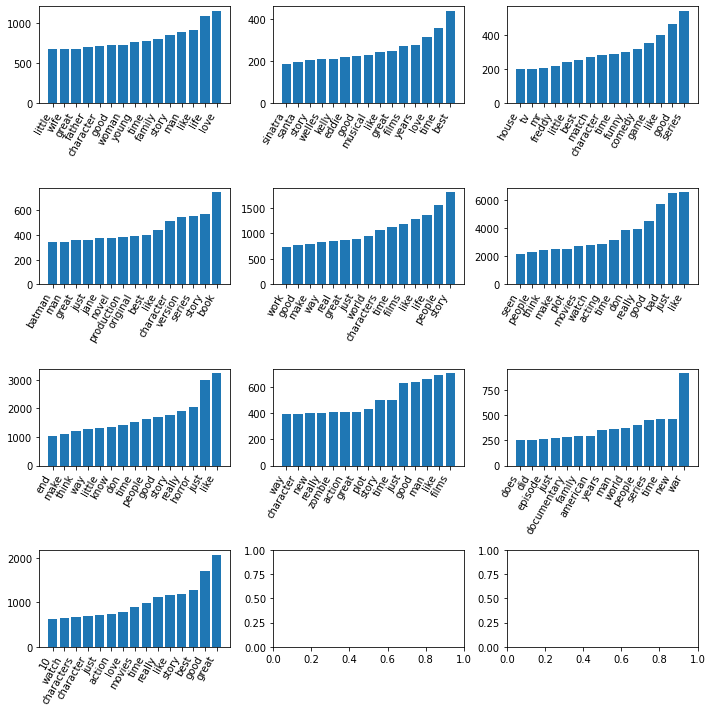

In [5]:
feature_names = np.array(vect.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), lda.components_):
    plot_important_features(coef, feature_names, top_n=15, ax=ax)
    
plt.tight_layout()

In [17]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch")
X_lda100 = lda100.fit_transform(X_train)


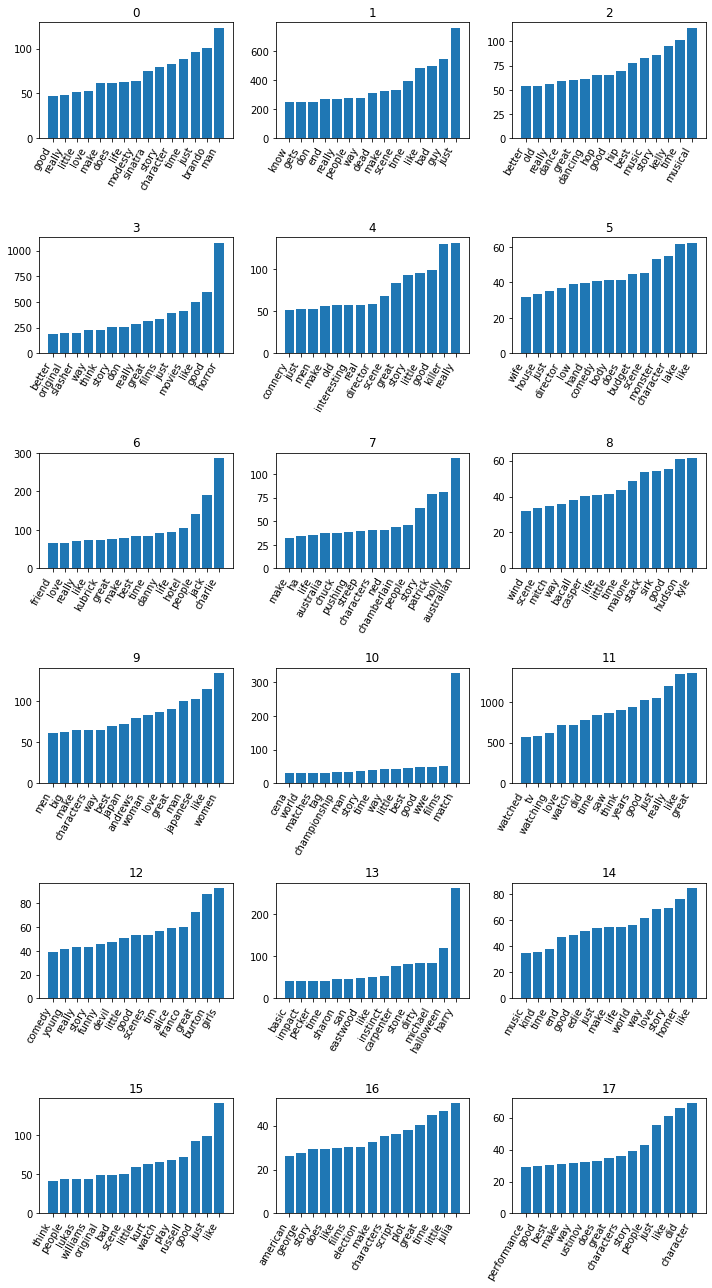

In [19]:
large_comp_inds = np.argsort(X_lda100.mean(axis=0))[-50:][::-1]

feature_names = np.array(vect.get_feature_names())
n_components = 15
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 18))
for i, (ax, coef) in enumerate(zip(axes.ravel(), lda100.components_[:, :])):
    plot_important_features(coef, feature_names, top_n=15, ax=ax)
    ax.set_title(i)
    
plt.tight_layout()

In [72]:
def print_topics(topics, feature_names, components, topics_per_chunk=6,
                 n_words=20):
    #sorting = np.argsort(components, axis=1)[:, ::-1]
    sorting= components
    
    
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for ii in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, ii]]))
            except:
                pass
        print("\n")

In [74]:
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
print_topics(np.argsort(X_lda100.sum(axis=0))[::-1][:30], feature_names, sorting, topics_per_chunk=8)


topic 79      topic 11      topic 1       topic 97      topic 52      topic 3       topic 26      topic 92      
--------      --------      --------      --------      --------      --------      --------      --------      
just          great         just          story         series        horror        family        sci           
like          like          guy           life          characters    good          man           fi            
bad           really        bad           people        story         like          story         like          
good          just          like          time          good          movies        husband       effects       
don           good          time          way           like          just          life          man           
really        years         scene         work          animation     films         wife          planet        
movies        think         make          great         just          great         young       

In [84]:
#assign topics to doc
#for i in range(20):
#    print(f"doc_{i} - topics {X_lda100[i][:20]}")
    
for i in range(20):
    print(f"doc_{i} - topic {np.argmax(X_lda100[i])} (words:{feature_names[sorting[np.argmax(X_lda100[i])]][:5]})")

doc_0 - topic 1 (words:['just' 'guy' 'bad' 'like' 'time'])
doc_1 - topic 74 (words:['story' 'great' 'girl' 'way' 'just'])
doc_2 - topic 11 (words:['great' 'like' 'really' 'just' 'good'])
doc_3 - topic 59 (words:['zombie' 'zombies' 'dead' 'people' 'gore'])
doc_4 - topic 52 (words:['series' 'characters' 'story' 'good' 'like'])
doc_5 - topic 44 (words:['episode' 'series' 'season' 'episodes' 'davis'])
doc_6 - topic 85 (words:['kelly' 'sinatra' 'good' 'like' 'plot'])
doc_7 - topic 70 (words:['like' 'time' 'rain' 'just' 'pet'])
doc_8 - topic 52 (words:['series' 'characters' 'story' 'good' 'like'])
doc_9 - topic 79 (words:['just' 'like' 'bad' 'good' 'don'])
doc_10 - topic 19 (words:['victoria' 'good' 'queen' 'demons' 'albert'])
doc_11 - topic 50 (words:['like' 'good' 'just' 'character' 'funny'])
doc_12 - topic 79 (words:['just' 'like' 'bad' 'good' 'don'])
doc_13 - topic 89 (words:['story' 'horror' 'series' 'lee' 'house'])
doc_14 - topic 79 (words:['just' 'like' 'bad' 'good' 'don'])
doc_15 - t



# Hyper-Parameters

- $\alpha$ (or $\theta$) = doc_topic_prior
- $\beta$ (or $\eta$) = topic_word_prior
- Both dirichlet distributions
- Large value $\xrightarrow[]{}$ more dispersed
- Small value $\xrightarrow[]{}$ more concentrated


<img src="./images/lda_params.png" style="width: 600px;">




# Rough overview of MCMC and Gibbs sampling



# Markov-Chain Monte-Carlo (MCMC)

**Goal**: Sample from complex distribution $p(X_1, ... X_n)$.

**Monte Carlo algorithm**: "correct in expectation" / "correct on average"

**Markov Chain**: a sequence of probability distribution, each depending only on the previous state.

**Markov Chain Monte Carlo**: a sequence of probability distributions so that on average you sample from the target distribution.

(The stationary distribution of the Markov chain is the target distribution $p$)



# Gibbs Sampling

**Goal**: Sample from complex distribution $p(X_1, ... X_n)$.

**Assumption**: Can sample from conditional $p(X_i|X_{j\neq i})$



<br>
Initialize
<br>
Start from random initialization $(x^0_1, ..., x^0_n)$

Construct $x^{k+1}$ from $x^k$:

$$ x^{k+1}_0 \propto  p(X_i| x^{k}_{1}, ..., x^{k}_{n})$$

$$ x^{k+1}_i \propto  p(X_i|x^{k+1}_0, ..., x^{k+1}_{i-1}, x^{k}_{i+1}, ..., x^{k}_{n})$$






# (Block) Gibbs Sampling for LDA

<img src="./images/lda_params.png" style="width: 600px;">



Updates sampled from:

$p(z_{iv} = k \, \vert \, \mathbf{\theta}_i, \phi_k) \propto \exp(\log \theta_{ik} + \log \phi_{k, y_{iv}})$

$p(\theta_i \, \vert \, z_{iv} = k, \phi_k) = \text{Dir}(\alpha + \sum_l \mathbb{I}(z_{il} = k))$

$p(\phi_k \, \vert \, z_{iv} = k, \mathbf{\theta}_i) = \text{Dir}(\beta + \sum_i \sum_l \mathbb{I}(y_{il} = v, z_{il} = k))$




# Collapsed Gibbs Sampling for LDA

<img src="./images/lda_params.png" style="width: 600px;">


Sample only $p(z_i=k|\mathbf{z}_{-i})$

Compute $\theta$, $\phi$ from $\mathbf{z}$


# Further Reading

- Rethinking LDA: Why Priors Matter - Hanna Wallach
- LDA Revisited: Entropy, Prior and Convergence –
Zhang et. al.


# Matrix Factorization

<br>
<img src="./images/matrix_factorization.png" style="width: 600px;">



# Matrix Factorization



<img src="./images/matrix_factorization_2.png" style="width: 600px;">

sklearn speak: `A = mf.transform(X)`




# PCA

<br>

<img src="./images/pca.png" style="width: 600px;">



# Latent Semantic Analysis (LSA)

- Reduce dimensionality of data.
- Can't use PCA: can't subtract the mean (sparse data)
- Instead of PCA: Just do SVD, truncate.
- "Semantic" features, dense representation.
- Easy to compute - convex optimization

In [18]:
print(X_train.shape)

from sklearn.decomposition import TruncatedSVD
lsa = TruncatedSVD(n_components=100)
X_lsa = lsa.fit_transform(X_train)
lsa.components_.shape


(18750, 26619)


(100, 26619)

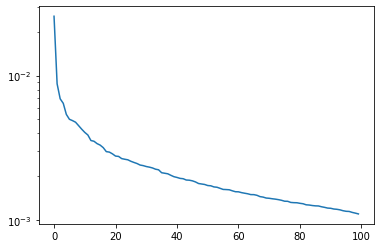

In [87]:
plt.semilogy(lsa.explained_variance_ratio_)

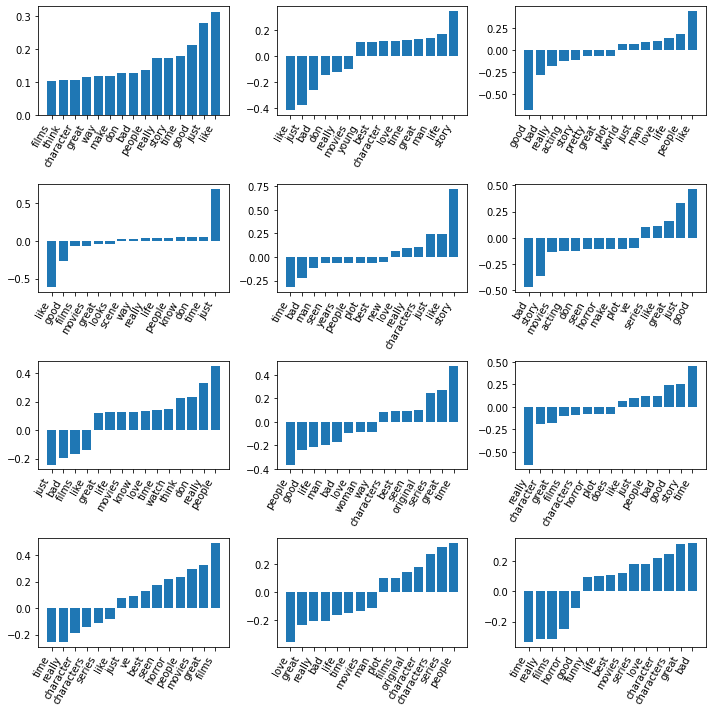

In [90]:
feature_names = np.array(vect.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), lsa.components_):
    plot_important_features(coef, feature_names, top_n=15, ax=ax)
    
plt.tight_layout()

In [19]:
# Scale before LSA


from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_train)

lsa_scaled = TruncatedSVD(n_components=100)
X_lsa_scaled = lsa_scaled.fit_transform(X_scaled)



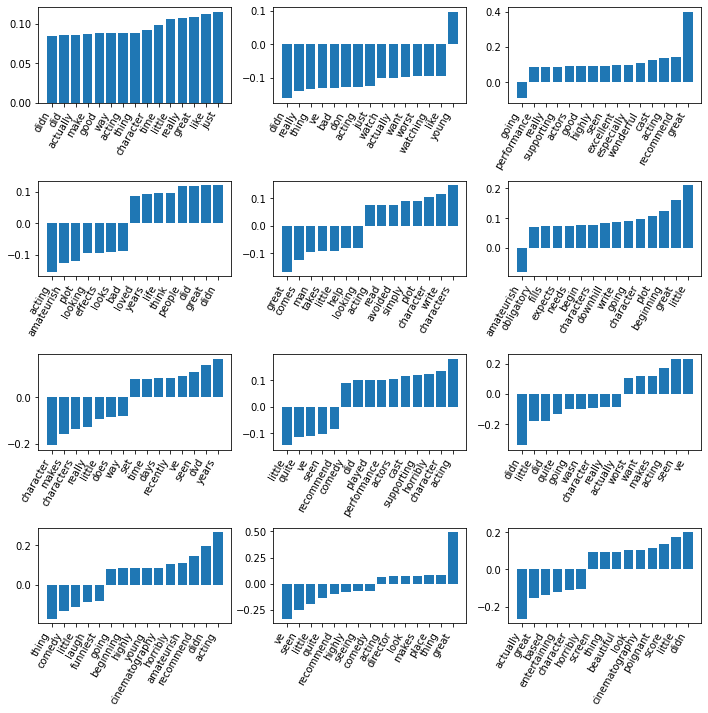

In [20]:
feature_names = np.array(vect.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), lsa_scaled.components_):
    plot_important_features(coef, feature_names, top_n=15, ax=ax)
    
plt.tight_layout()



# NMF for topic models

<img src="./images/nmf.png" style="width: 600px;">




# NMF Loss and algorithm

Frobenius loss / squared loss ($ Y = H W$):

$$ l_{\text{frob}}(X, Y) = \sum_{i,j} (X_{ij} - Y_{ij})^ 2$$

Kulback-Leibler (KL) divergence:
$$ l_{\text{KL}}(X, Y) = \sum_{i,j} X_{ij} \log\left(\frac{X_{ij}}{Y_{ij}}\right) - X_{ij}  + Y_{ij}$$

s.t. H, W all entries positive




optimization :
- Convex in either W or H, not both.
- Randomly initialize (PCA?)
- Iteratively update W and H (block coordinate descent)





Transforming data:

- Given new data `X_test`, fixed `W`, computing `H` requires optimization.



# NMF for topic models

<center>
<img src="./images/nmf_1.png" style="width: 600px;">
</center>


/Users/jonathan.schler/anaconda3/envs/python37/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


violation: 1.0
violation: 0.5251275171498115
violation: 0.6166364073660392
violation: 0.4769833505741811
violation: 0.37800436971868756
violation: 0.3059424615027273
violation: 0.25533937130307666
violation: 0.2155697943833698
violation: 0.17789914460372724
violation: 0.14675545780898508
violation: 0.12138686313580431
violation: 0.10121204471638066
violation: 0.08646683439564527
violation: 0.07555711884669991
violation: 0.0676576202959201
violation: 0.061743183043408145
violation: 0.0571102138271619
violation: 0.05306294227898143
violation: 0.04955186539018817
violation: 0.04621299897761701
violation: 0.0430850706745924
violation: 0.040183259097812465
violation: 0.037338801202503456
violation: 0.03469308496512478
violation: 0.03235412299213772
violation: 0.03025716012739256
violation: 0.02842034595556822
violation: 0.026852176933114754
violation: 0.025505156007459957
violation: 0.024326916749666517
violation: 0.02335232993233701
violation: 0.022530765373002092
violation: 0.021868695399

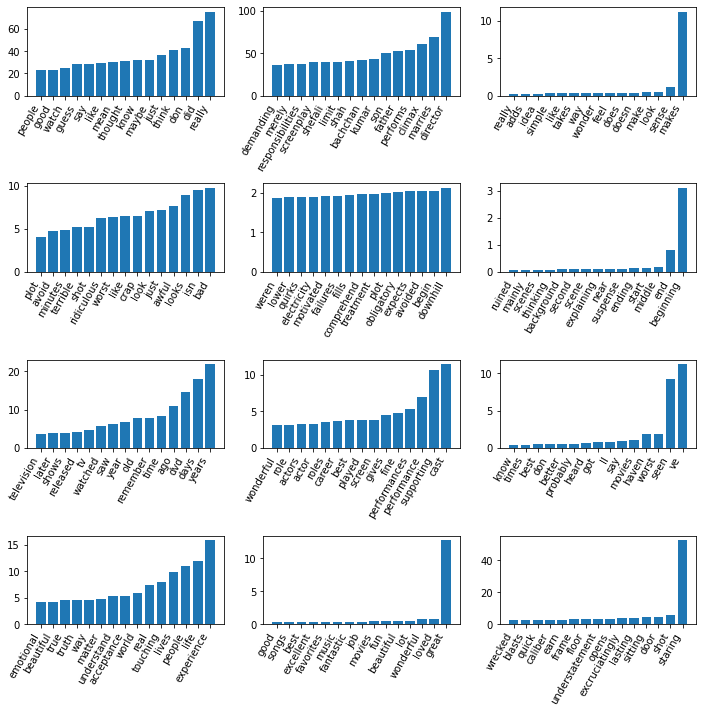

In [21]:
from sklearn.decomposition import NMF

nmf_scale = NMF(n_components=100, verbose=10, tol=0.01)
nmf_scale.fit(X_scaled)

feature_names = np.array(vect.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), nmf_scale.components_):
    plot_important_features(coef, feature_names, top_n=15, ax=ax)
    
plt.tight_layout()




# Part 2: Beyond Bags of Words

Limitations of bag of words:
- Semantics of words not captured
- Synonymous words not represented
- Very distributed representation of documents



# In first part we saw..

- Latent Semantic Analysis
- Non-negative Matrix Factorization
- Latent Dirichlet Allocation
- All embed documents into a continuous, corpus specific
space.
- Now: Embed words in a “general” space (mostly).



# Idea

- Unsupervised extraction of semantics using large
corpus (wikipedia etc)
- Input: one-hot representation of word (as in BoW).
- Use auxiliary task to learn continuous
representation.




# Skip-Gram models

- Given a word, predict surrounding word
- Supervised task, each document yields many
examples
- Not interested in performance for this task, just
want to learn representations.





# Example
```
[“What is my purpose?”, “You pass the butter.”]
```

<img src="./images/context_window.png" style="width: 600px;">


Using context windows of size 1 (in practice 5 or 10):




<table>
    <tr><td><center>skippgram</center></td><td><center>CBOW</center></td></tr>
    <tr><td><img src="./images/skip_gram_net_arch.png" style="width: 600px;">
    </td><td><img src="./images/cbow_skipgram_1.png" style="width: 600px;">
    </td></tr>
    </table>
(http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)



# Softmax Training

<img src="./images/softmax.png" style="width: 600px;">




<a href="http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf">Mikolov et. al. - Distributed Representations of Words and Phrases and their Compositionality (2013)</a>



# CBOW vs Skip-gram


<img src="./images/cbow_skipgram.png" style="width: 600px;">

Efficient Estimation of Word Representations in Vector Space https://arxiv.org/pdf/1301.3781.pdf




# Implementations

- Gensim
- Word2vec
- Tensorflow
- fasttext
- ...
- Don't train yourself



# Quick intro to spaCy
Comes with pretrained models, we'll need the "large model":
```
python -m spacy download en_core_web_lg
```




In [22]:
import spacy


In [23]:
nlp = spacy.load("en_core_web_lg")
doc = nlp("What is my purpose?")
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_,
          token.dep_, token.shape_, token.is_alpha, token.is_stop)

What what PRON WP attr Xxxx True True
is be AUX VBZ ROOT xx True True
my my PRON PRP$ poss xx True True
purpose purpose NOUN NN nsubj xxxx True False
? ? PUNCT . punct ? False False



# Cosine Similarity

$$\Large \text{similarity}(v, w)=\cos(\theta) = \frac{v^Tw}{\lVert v\rVert \lVert w \rVert}$$




# Inspecting Semantics



In [24]:
txt=". ".join([d.decode().replace("<br />"," ") for d in text_trainval[:100]])
doc = nlp(txt)

In [25]:
queries = [w for w in nlp.vocab if w.is_lower and w.prob >= -20]

def most_similar(word, count=10):
    by_similarity = sorted(queries, key=lambda w: word.similarity(w), reverse=True)
    return [w.orth_ for w in by_similarity[:count]]

most_similar(nlp("movie"))

/Users/jonathan.schler/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  after removing the cwd from sys.path.


['movie',
 'movies',
 'film',
 'films',
 'flick',
 'starring',
 'soundtrack',
 'cinema',
 'remake',
 'comedy']

In [26]:
most_similar(nlp("good"), count=15)

/Users/jonathan.schler/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  after removing the cwd from sys.path.


['good',
 'great',
 'better',
 'very',
 'nice',
 'really',
 'excellent',
 'decent',
 'well',
 'but',
 'much',
 'too',
 'bad',
 'enough',
 'kind']

In [27]:
most_similar(nlp("nice horse"))

/Users/jonathan.schler/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  after removing the cwd from sys.path.


['horse',
 'nice',
 'horses',
 'good',
 'pony',
 'great',
 'pretty',
 'very',
 'little',
 'lovely']

In [31]:
doc = nlp("nice horse")
print(doc.vector.shape)
np.all(doc.vector == (nlp("nice").vector + nlp("horse").vector) / 2)
#doc.vector

(300,)


True



# Prepare document (IMDB)


```python
print(text_train_sub[0].decode())
```
```
Maybe it's just because I have an intense fear of hospitals and medical stuff, but this one got under my skin
(pardon the pun). This piece is brave, not afraid to go over the top and as satisfying as they come in terms
of revenge movies. Not only did I find myself feeling lots of hatred for the screwer and lots of sympathy
towards the "screwee", I felt myself cringe and feel pangs of disgust at certain junctures which is really a
rare and delightful thing for a somewhat jaded horror viewer like myself. Some parts are very reminiscant of
"Hellraiser", but come off as tribute rather than imitation. It's a heavy handed piece that does not offer
the viewer much to consider, but I enjoy being assaulted by a film once and awhile. This piece brings it and
doesn't appologize.
I liked this one a lot. Do NOT watch whilst eating pudding.
```

```python
# skip some annotations for faster processing
nlp = spacy.load("en_core_web_lg", disable=["tagger", "parser", "ner"])
docs_train = [nlp(d.decode()).vector for d in text_train_sub]
X_train = np.vstack(docs_train)
X_train.shape
```
```
(18750, 300)
```
]


In [ ]:
# takes a long time don't run again

nlp = spacy.load("en_core_web_lg", disable=["tagger", "parser", "ner","lemmatizer"])
docs_train = [nlp(d.decode()).vector for d in text_train]
X_train = np.vstack(docs_train)
X_train.shape

In [81]:
from sklearn.linear_model import LogisticRegression

lr_w2v = LogisticRegression().fit(X_train, y_train)
lr_w2v.score(X_train, y_train)

/Users/jonathan.schler/anaconda3/envs/python37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8581333333333333

In [82]:
# long time don't run again

# Classification of average vector

docs_val = [nlp(d.decode()).vector for d in text_val]
X_val = np.vstack(docs_val)
lr_w2v.score(X_val, y_val)

0.84768


# Classification of average vectors


```python
lr_w2v = LogisticRegression().fit(X_train, y_train_sub)
lr_w2v.score(X_train, y_train_sub)
```
```
0.867
```
```python
docs_val = [nlp(d.decode()).vector for d in text_val]
X_val = np.vstack(docs_val)
lr_w2v.score(X_val, y_val)
```
```
0.857
```




# Analogues and Relationships


<img src="./images/king_queen.png" style="width: 600px;">



Answer “King is to Kings as Queen is to ?”:<br/>
Find closest vector to vec(“Queen”) + (vec(“Kings”) - vec(“King”))



<a href="http://www.aclweb.org/anthology/N13-1090">Mikolov et. al. Linguistic Regularities in Continuous Space Word Representations (2013)</a>


<img src="./images/analogues.png" style="width: 600px;">


<a href="http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf">Mikolov et. al. - Distributed Representations of Words and Phrases and their Compositionality (2013)</a>


# Finding Relations
<br />
$$\large a : b : : c : ?$$
<br />
$$\large d = \text{arg}\max_i\frac{\left(\text{vec}(b) - \text{vec}(a) + \text{vec}(c)\right)^T vec_i}{\lVert\text{vec}(b) - \text{vec}(a) + \text{vec}(c)\rVert\lVert \text{vec}_i\rVert}$$


<img src="./images/table_cities_states.png" style="width: 600px;">
<a href="https://cs224d.stanford.edu/lecture_notes/notes2.pdf">Stanford CS 224D: Deep Learning for NLP</a>



# Examples with spaCy


```python
def most_similar_vec(vec, count=10):
    by_similarity = sorted(queries, key=lambda w: cos_sim(w.vector, vec), reverse=True)
    return [w.orth_ for w in by_similarity[:count]]

vec = nlp('woman').vector + nlp('king').vector - nlp("man").vector
most_similar_vec(vec)
```
```
['king', 'queen', 'prince', 'kings', 'princess', 'royal', 'throne', 'queens', 'monarch', 'kingdom']
```
```python
vec = nlp('woman').vector - nlp("man").vector + nlp('he').vector 
most_similar_vec(vec)
```
```
['she', 'woman', 'he', 'her', 'herself', 'mother', 'wife', 'who', 'told', 'when']
```
```python
vec = nlp('paris').vector - nlp('berlin').vector + nlp('germany').vector 
most_similar_vec(vec)
```
```
['france', 'paris', 'europe', 'germany', 'italy', 'spain', 'japan', 'european', 'poland', 'usa']
```



In [91]:
from sklearn.metrics.pairwise import cosine_similarity

def cos_sim(a, b):
    return cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))

def most_similar_vec(vec, count=10):
    by_similarity = sorted(queries, key=lambda w: cos_sim(w.vector, vec), reverse=True)
    return [w.orth_ for w in by_similarity[:count]]




In [92]:
vec = nlp('woman').vector - nlp("man").vector + nlp('he').vector 
most_similar_vec(vec)

['she',
 'woman',
 'he',
 'her',
 'herself',
 'mother',
 'wife',
 'who',
 'told',
 'when']

In [93]:
vec = nlp('woman').vector + nlp('king').vector - nlp("man").vector
most_similar_vec(vec)

['princess',
 'lady',
 'woman',
 'mother',
 'goddess',
 'wife',
 'daughter',
 'girl',
 'pregnant',
 'sister']

In [96]:
vec = nlp('good').vector + nlp('worse').vector - nlp("bad").vector
most_similar_vec(vec)

['better',
 'good',
 'worse',
 'much',
 'even',
 'but',
 'though',
 'far',
 'decent',
 'well']




# GloVe: Global Vectors for Word Representation


$X_{ij}$ = How often does work j appear in context of word i

$$ J = \sum\limits_{i,j=1}^{V} f(X_{ij}) (w_i^T \tilde{w_j} + b_i + \tilde{b_j} - \log X_{ij})^2$$


$$
f(x) =
\begin{cases}
  (x/x_\text{max})^\alpha & \text{if  } x < x_\text{max}  \\
  1 & \text{otherwise} \\
\end{cases}
$$


https://nlp.stanford.edu/projects/glove/





# GloVe  Weighting function f

<img src="./images/glove_weighting.png" style="width: 600px;">



# Word analogies

<img src="./images/word_analogies.png" style="width: 600px;">





<br>
<img src="./images/paper_title.png" style="width: 600px;">


<br>

<br>

$\overrightarrow{man} - \overrightarrow{woman} \approx \overrightarrow{king} - \overrightarrow{queen}$

<br>
<br>

$\overrightarrow{man} - \overrightarrow{woman} \approx \overrightarrow{computer programmer} - \overrightarrow{homemaker}$


]


# Going along he-she direction:

<br>
<img src="./images/he_she.png" style="width: 600px;">




# Paragraph Vectors



# Doc2Vec

<br>

<img src="./images/doc2vec.png" style="width: 600px;">


<a href="https://cs.stanford.edu/~quocle/paragraph_vector.pdf">Le, Mikolov: Distributed Representations of Sentences and Documents (2014)</a>



# Doc2Vec with gensim


```python
def read_corpus(text, tokens_only=False):
    for i, line in enumerate(text):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(
                gensim.utils.simple_preprocess(line), [i])

train_corpus = list(read_corpus(text_train_sub))
test_corpus = list(read_corpus(text_val, tokens_only=True))

model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2)
model.build_vocab(train_corpus)

model.train(train_corpus, total_examples=model.corpus_count, epochs=55)
```




https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb



# Validation of Word Vectors
```python
model.wv.most_similar("movie")
```
```
[('film', 0.948),
 ('flick', 0.822),
 ('series', 0.715),
 ('programme', 0.703),
 ('sequel', 0.693),
 ('story', 0.677),
 ('show', 0.655),
 ('documentary', 0.653),
 ('picture', 0.642),
 ('thriller', 0.630)]
 ```


# Encoding using doc2vec


```python
vectors = [model.infer_vector(train_corpus[doc_id].words)
          for doc_id in range(len(train_corpus))]

X_train = np.vstack(vectors)

X_train.shape
```
```
(18759, 50)
```
```python
test_vectors = [model.infer_vector(test_corpus[doc_id])
                for doc_id in range(len(test_corpus))]
X_test = np.vstack(test_vectors)
```





```python
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100).fit(X_train, y_train_sub)

lr.score(X_train, y_train_sub)
```
```
0.817
```
```python
lr.score(X_val, y_val)
```
```
0.803
```



# Transformer-based feature extraction
BERT, GPT3, ...
Bi-directional language models:
Using context + word order!
 
<img src="./images/bert_high_level.png" style="width: 600px;">


Huge compute effort and training data (multiple days on TPUs)




# Sentiment analysis using  ![](images/huggingface_logo.svg) (huggingface)

Off-the-shelf model on aclImdb (GPU suggested) 

```python
from transformers import pipeline

nlp = pipeline("sentiment-analysis")

res = [nlp(t.decode()) for t in text_val]
```
```
# my laptop couldn't handle it
```




# BERT for feature extraction

```python
from transformers import pipeline

nlp = pipeline("feature-extraction")

X_train = [nlp(t.decode() for t in text_train]
```
Use similar to word vectors (can train logistic regression etc)

Better: fine tuning (later in the semester?)




# Questions ?


    